# DeepFM

## 0. Imports

In [142]:
# Basic Data Analysis Tools
import numpy as np
import pandas as pd
from os.path import exists
import itertools
from ast import literal_eval

# Keras imports for deepFM, 1st & 2nd order FM: all of which can be implemented as neural networks
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [169]:
# Notebook Hyperparameters
predict_only_new_products = True # only new prosucts - True, all products - False
prod_class="family" # variation, product, family

In [170]:
def transaction_preprocess(transactions, train_bounds, test_bounds, prod_class="variation", time_period = 125):
    """
    args:
        transactions: pd.DataFrame -> the transaction_history.csv provided by Siemens
        train_bounds, test_bounds: (lower: int, upper: int) -> bounds for splitting dataset into train and test based on "day" feature
        time_period: map day feature into month, years, etc. (default 125 days = 4 months)
    returns:
        transactions: pd.DataFrame -> processed dataframe with encoded categories and mapped days
        train_rnd_sample: pd.DataFrame -> all positive samples within train as well as an equal number of randomly sampled negative samples
        test_rnd_sample: pd.DataFrame -> 
    """
    transactions = transactions.copy() 
    
    # encode categorical variables
    transactions["customer"] = transactions["customer"].astype('category').cat.codes + 1    
    transactions["day"] = transactions["day"] // time_period # map days to weeks, months, years
    if prod_class == "product":
        transactions["prod"] = transactions["prod"].str.split("_").apply(lambda x: x[0].join(x[1]))
    elif prod_class == "family":
        transactions["prod"] = transactions["prod"].str.split("_").apply(lambda x: x[0])
    
    transactions["prod"] = transactions["prod"].astype('category').cat.codes 
    transactions["state"] = transactions["state"].astype('category').cat.codes + 1
    transactions["ind_code"] = transactions["ind_code"].astype('category').cat.codes + 1
    transactions["ind_seg_code"] = transactions["ind_seg_code"].astype('category').cat.codes + 1
    
    # set labels to 1 - all products present were bought
    transactions["label"] = 1
    
    # create product customer list
    transactions["prod_customer"] = list(zip(transactions["customer"], transactions["prod"]))
    # drop rows with missing values
    transaction = transactions.dropna()
    
    # create train & test set
    train = transactions[(transaction.day >= train_bounds[0] // time_period) & (transactions.day < train_bounds[1] // time_period)]
    test = transactions[(transaction.day >= test_bounds[0] // time_period) & (transactions.day < test_bounds[1] // time_period)]
    print(len(test))
    
    # get unique customer and product lists
    customers = transactions["customer"].unique()
    products = train["prod"].unique() # transactions["prod"].unique() # use products only from train to make sure
    train_products_set = set(products)
    train_customers_set = set(customers)
    
    # Remove missing from test products
    print(f"LEN {len(test)}")
    test = test[test["prod"].apply(lambda x: x in train_products_set)]
    print(len(test))
    test = test[test["customer"].apply(lambda x: x in train_customers_set)]
    print(len(test))
    
    # set of day-customer-bought product for negative sampling
    hit_combo = set(list(zip(transactions["day"], transactions["customer"], transactions["prod"])))
    
    # get days and customers
    test_days = test["day"].unique()
    hit_combo_2 = list(zip(test["day"], test["customer"], test["prod"]))
    
    prod_list = set(products) 
    test_customer_prod_day = set([tuple(r) for r in test[["day", "customer", "prod"]].to_numpy()]) # Set of positive test_days x customer x prod
    all_test_customer_prod_day = set([x for x in itertools.product(test_days, customers, products)]) # Set of all test_days x customer x prod
    neg_test_customer_prod_day = all_test_customer_prod_day - test_customer_prod_day # Set of negative test_days x customer x prod
    
    # Create test dataset
    final_neg_sampl = test[["customer", "domestic", "state",
                            "ind_code", "ind_seg_code"]].drop_duplicates() # customer info - customer_id unique identifier of customer
    final_neg_sampl = final_neg_sampl.merge(pd.DataFrame(neg_test_customer_prod_day, columns=["day", "customer", "prod"]), how="inner", on="customer") # cartezian product of product, customer, day and customer info
    final_neg_sampl["label"] = 0 # set all products as unbought (non-sampled)
    test["label"] = 1 # set all products present in test as positive
    final_neg_sampl = final_neg_sampl.append(test.drop(["new_orders", "prod_customer"],axis=1)) # join positive and negative
    final_neg_sampl = final_neg_sampl.drop_duplicates()

    
    # specify train sample size (c)
    SAMPLE_SIZE = int(np.ceil(1.0 * len(train))) # Set negative train size
    train_days = train["day"].unique()
    
    # Bootstrap negative sample train set (only samples from train set were used) - in case no bootstraping is desired change replace -> False
    # Removes potential outliers which have for example bought only one item or that are highly unlikely to buy an item
    train_rnd_sample = np.array([np.random.choice(train_days, size=SAMPLE_SIZE),\
                                              np.random.choice(customers, size=SAMPLE_SIZE),\
                                              np.random.choice(products, size=SAMPLE_SIZE)]).T
    
    # remove samples that were actually bought (are in hit_combo)
    not_faulty = [tuple(train_rnd_sample[row,:]) not in hit_combo for row in range(train_rnd_sample.shape[0])]
    train_rnd_sample = train_rnd_sample[not_faulty]
    
    # Drop duplicated rows
    train_rnd_sample = pd.DataFrame(train_rnd_sample,
                                   columns=["day", "customer", "prod"]).drop_duplicates()
    
    # Add customer info - uniquely defined by customer_id
    train_rnd_sample = train_rnd_sample.merge(transactions[["customer", "domestic", "state", "ind_code",
                                                            "ind_seg_code"]].drop_duplicates(),
                                              on="customer")
    train_rnd_sample["label"] = 0 # Set negative labels
    
    # Merge positive and negative train samples
    train_rnd_sample = train_rnd_sample.append(train[["day", "customer", "prod", "domestic", "state", "ind_code",
                                                            "ind_seg_code", "label"]], ignore_index=True)
    
    return transactions, train_rnd_sample.sample(frac=1).reset_index(drop=True), final_neg_sampl, products, customers

In [171]:
transactions = pd.read_csv("dataset/transaction_history.csv") # load dataset
transformations = [] # includes train, test folds for CV

# create CV folds (train - 500 days, test - 125 days)
for i in range(6):
    print(f"Iteration {i}", end="\r")
    transformed, train, test, products, customers = transaction_preprocess(transactions, (i*125, (i+4)*125), ((i+4)*125, (i+5)*125), prod_class=prod_class) 
    transformations.append((train, test))
train, test = transformations[0]

17025tion 0
LEN 17025
16945
16945
6576
17498tion 1
LEN 17498
17427
17427
6925
19688tion 2
LEN 19688
19599
19599
7442
23882tion 3
LEN 23882
23728
23728
8217
21917tion 4
LEN 21917
21834
21834
7746
22424tion 5
LEN 22424
22325
22325
7915


## 1. Models

### 1.1 Model parts

In [172]:
def define_input_layers(df):
    """
    Defines input layers for all ML models used in this notebook.
    
    args:
        transactions: pd.DataFrame -> the transformed transaction history, with encoded categories
    returns:
        inputs: keras.inputs -> 'day', 'customer', 'prod', 'state', 'ind_code', 'ind_seg_code', 'domestic'
    """
    day_input = Input((1,), name = 'day')
    num_inputs = [day_input] # continuous numeric inputs
    cat_input = [Input((1,), name= col) for col in ['customer', 'prod', 'state', 'ind_code',
       'ind_seg_code', 'domestic']] # discrete categorical inputs
    cat_sl_inputs = [cat_input] 

    inputs = num_inputs + cat_sl_inputs # join inputs
    
    return inputs

inputs = define_input_layers(transformed)

In [173]:
def Tensor_Mean_Pooling(name = 'mean_pooling', keepdims = False):
    return Lambda(lambda x: K.mean(x, axis = 1, keepdims=keepdims), name = name)

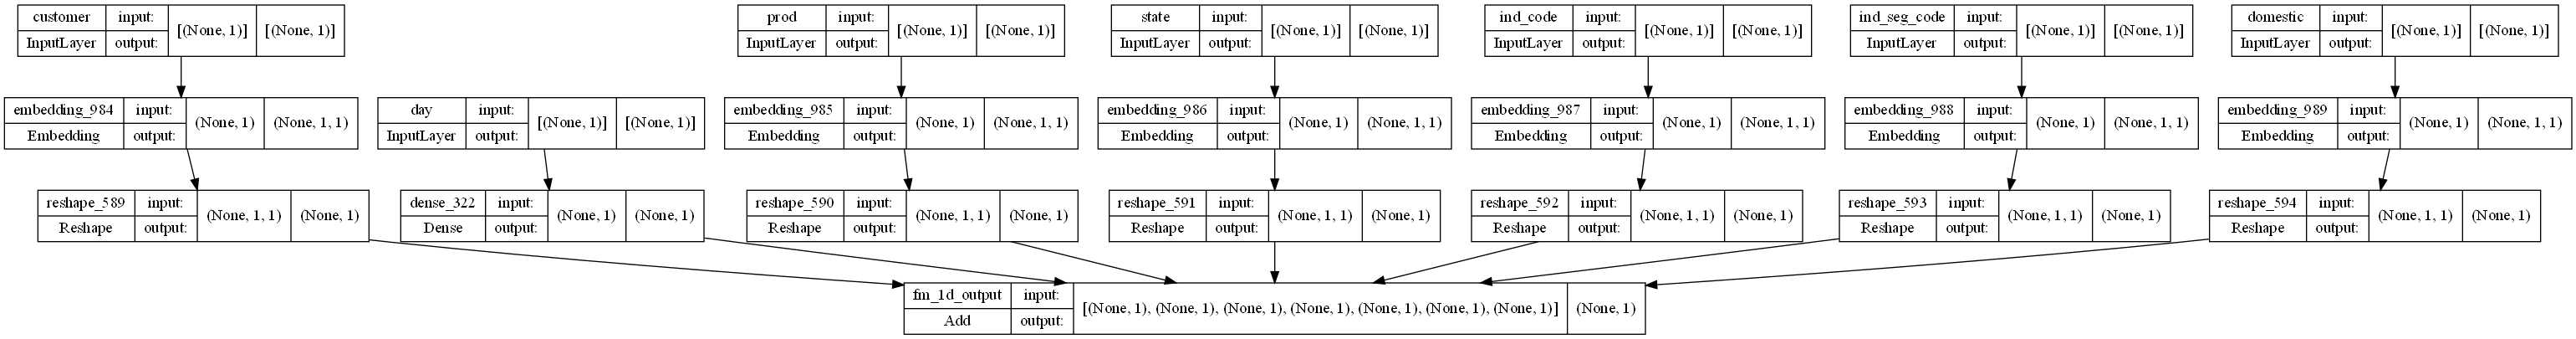

In [174]:
def fm_1d(inputs):
    """
    1st order FM output = sum a_i * f_i, linear combination of features
    
    args:
        inputs: inputs to neural network (specify shape of inputs)
    returns:
        y_fm_1d: keras.model for 1st order FM part 1
    """
    num_inputs, cat_inputs = inputs 
    
    # all tensors are reshape to (None, 1)
    num_dense_1d  = [Dense(1)(num_inputs)]
    
    cat_sl_embed_1d = [Embedding(transformed[inpt.name].nunique() + 1, 1)(inpt) for inpt in cat_inputs]  # embeed each input separatelly into lower dimension
    cat_sl_embed_1d = [Reshape((1,))(i) for i in cat_sl_embed_1d] # reshape inputs into proper shape for later layers
    
    # add all tensors
    y_fm_1d = Add(name = 'fm_1d_output')(num_dense_1d + cat_sl_embed_1d) # join all tensors toghether
    return y_fm_1d

# display 1st order FM model
y_1d = fm_1d(inputs)
fm_model_1d = Model(inputs, y_1d)
plot_model(fm_model_1d, show_shapes=True, show_layer_names=True)

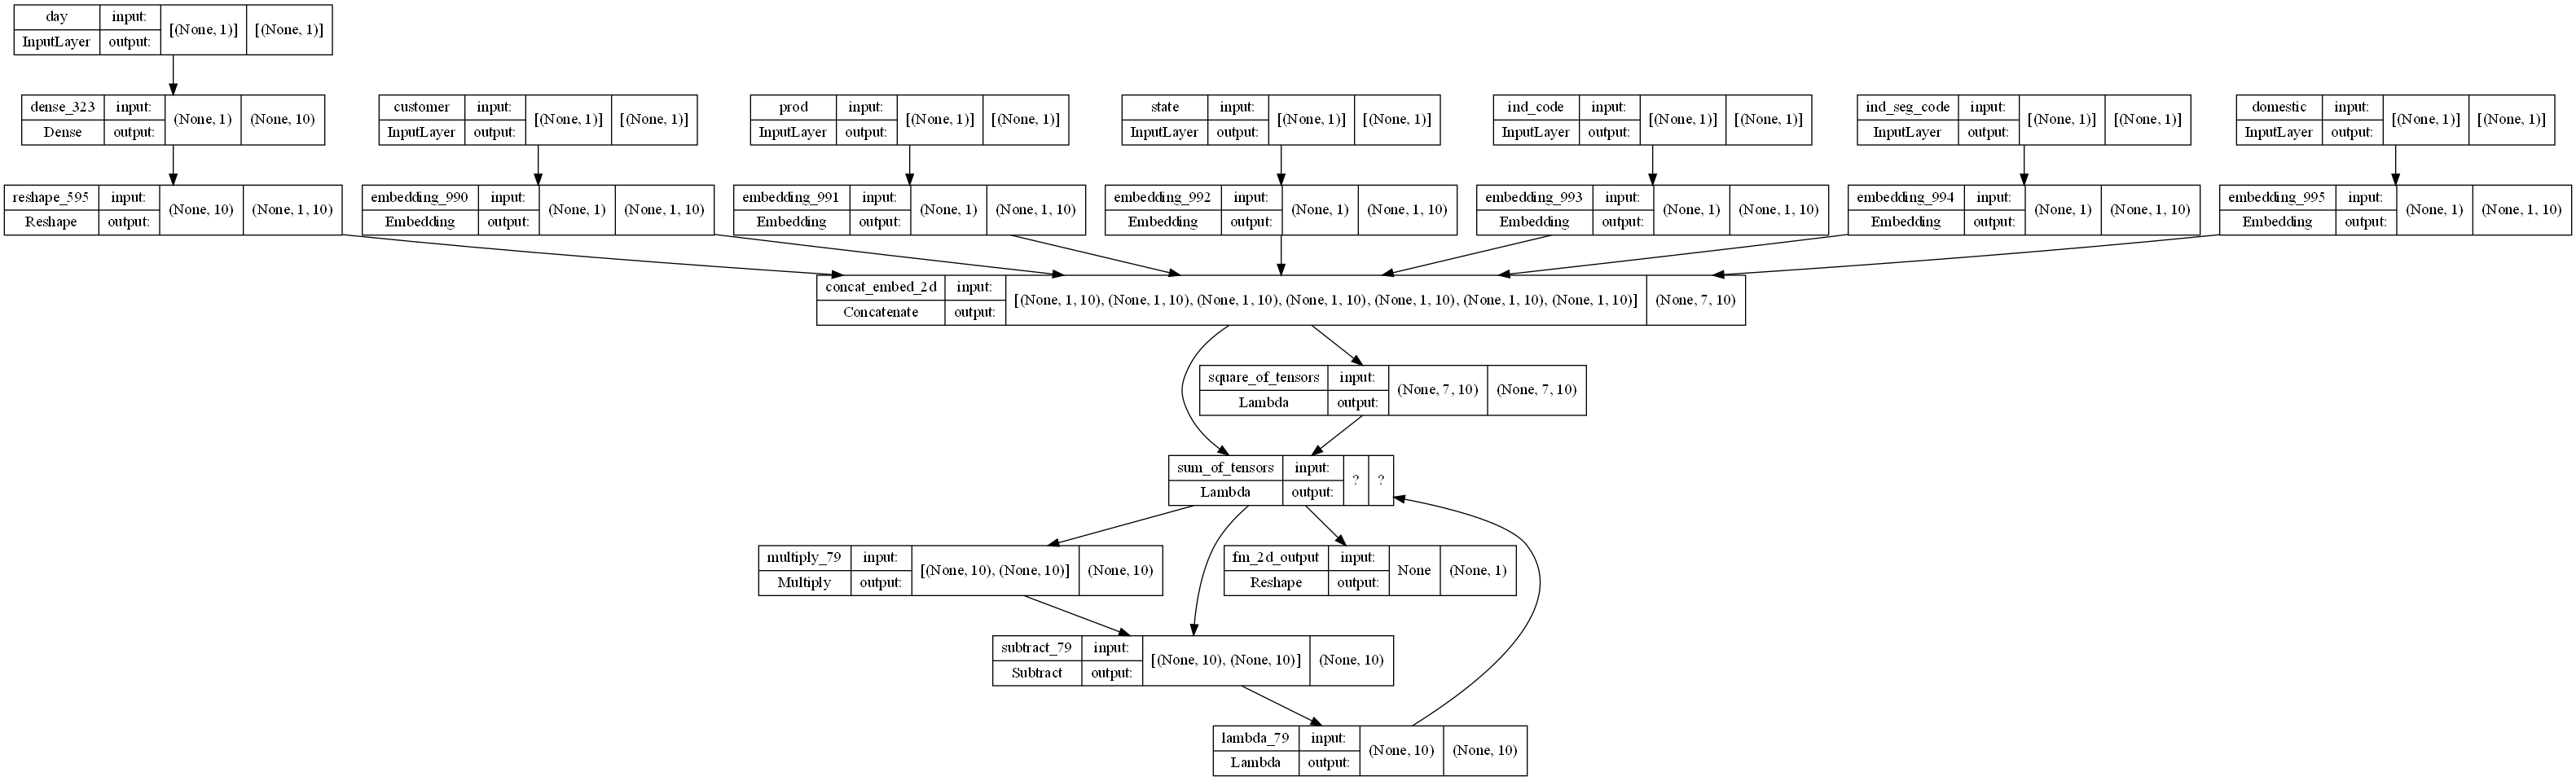

In [175]:
def fm_2d(inputs, k):
    """
    2nd order FM output = sum (a_i * f_i)^2, polynomial combination of features
    
    args:
        inputs: inputs to neural network (specify shape of inputs)
    returns:
        y_fm_2d: keras.model for 1st order FM part 1
        embed_2d: embedding layer to be used in other parts (DNN & LSTM)
    """
    num_inputs, cat_inputs = inputs # split inputs
    
    num_dense_2d = [Dense(k)(num_inputs)] # create k dense inputs for embedding layers
    num_dense_2d = [Reshape((1,k))(i) for i in num_dense_2d] # for each input create an input with k embedding dimension
    
    cat_sl_embed_2d = [Embedding(transformed[inpt.name].nunique() + 1, k)(inpt) for inpt in cat_inputs] # embed categorical features
    
    embed_2d = Concatenate(axis=1, name = 'concat_embed_2d')(num_dense_2d + cat_sl_embed_2d) # join embedding layers toghether
    
    tensor_sum = Lambda(lambda x: K.sum(x, axis = 1), name = 'sum_of_tensors')
    tensor_square = Lambda(lambda x: K.square(x), name = 'square_of_tensors')

    sum_of_embed = tensor_sum(embed_2d)
    square_of_embed = tensor_square(embed_2d)
    
    square_of_sum = Multiply()([sum_of_embed, sum_of_embed])
    sum_of_square = tensor_sum(square_of_embed)
    
    sub = Subtract()([square_of_sum, sum_of_square]) # basically variance
    sub = Lambda(lambda x: x*0.5)(sub) # just normalization (isn't necessary)
    y_fm_2d = Reshape((1,), name = 'fm_2d_output')(tensor_sum(sub))
    
    return y_fm_2d, embed_2d
    
y_2d, embed_2d = fm_2d(inputs, 10)
fm_model_2d = Model(inputs, y_2d)
plot_model(fm_model_2d, show_shapes=True, show_layer_names=True)

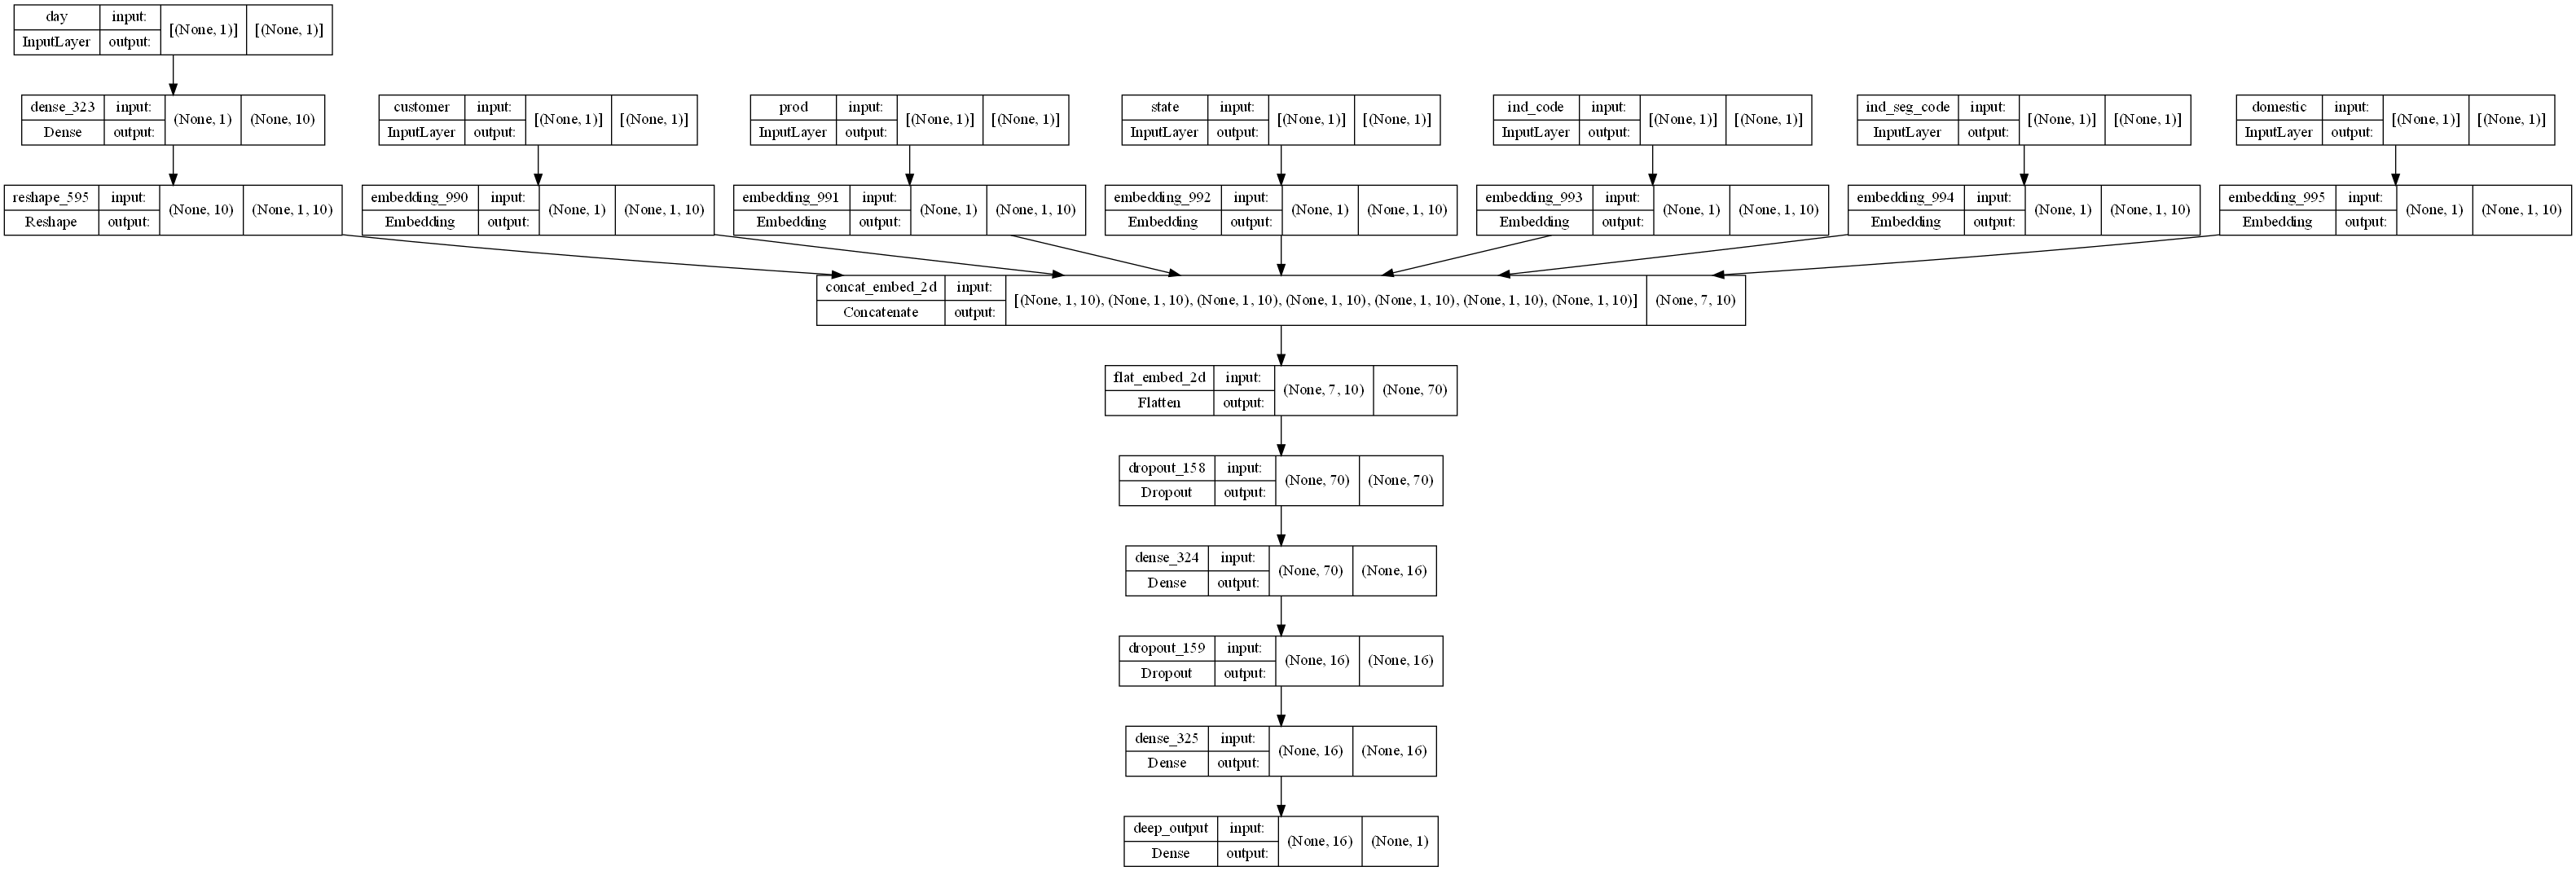

In [176]:
def dnn_part(embed_2d, dnn_dim, dnn_dr):
    """
    DNN output = simple vanilla neural network
    
    args:
        embed_2d: keras.inputs -> embeding layer from 2nd order FM same dimensionality as FM part (should perhaps be different)
        dnn_dim: arr[int] -> dnn layer dimensions 
        dnn_dr: float -> dropout rate, same for all layers
        k_reg: tuple[float, float] -> kernel weights regularization (L1, L2)
        a_reg: tuple[float, float] -> activation unit regularization (L1, L2)
        act_fun: ="relu"
    returns:
        y_dnn: keras.model for vanilla DNN
    """
    
    # flat embed layers from 3D to 2D tensors
    y_dnn = Flatten(name = 'flat_embed_2d')(embed_2d)
    
    # traverse through layers 
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn)
        y_dnn = Dense(h, activation='relu')(y_dnn)
    y_dnn = Dense(1, activation='relu', name = 'deep_output')(y_dnn)
    
    return y_dnn

# display DNN model
y_dnn = dnn_part(embed_2d, [16, 16], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

0.0001
(0.0001, 0.0001)
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'deep_output')>]


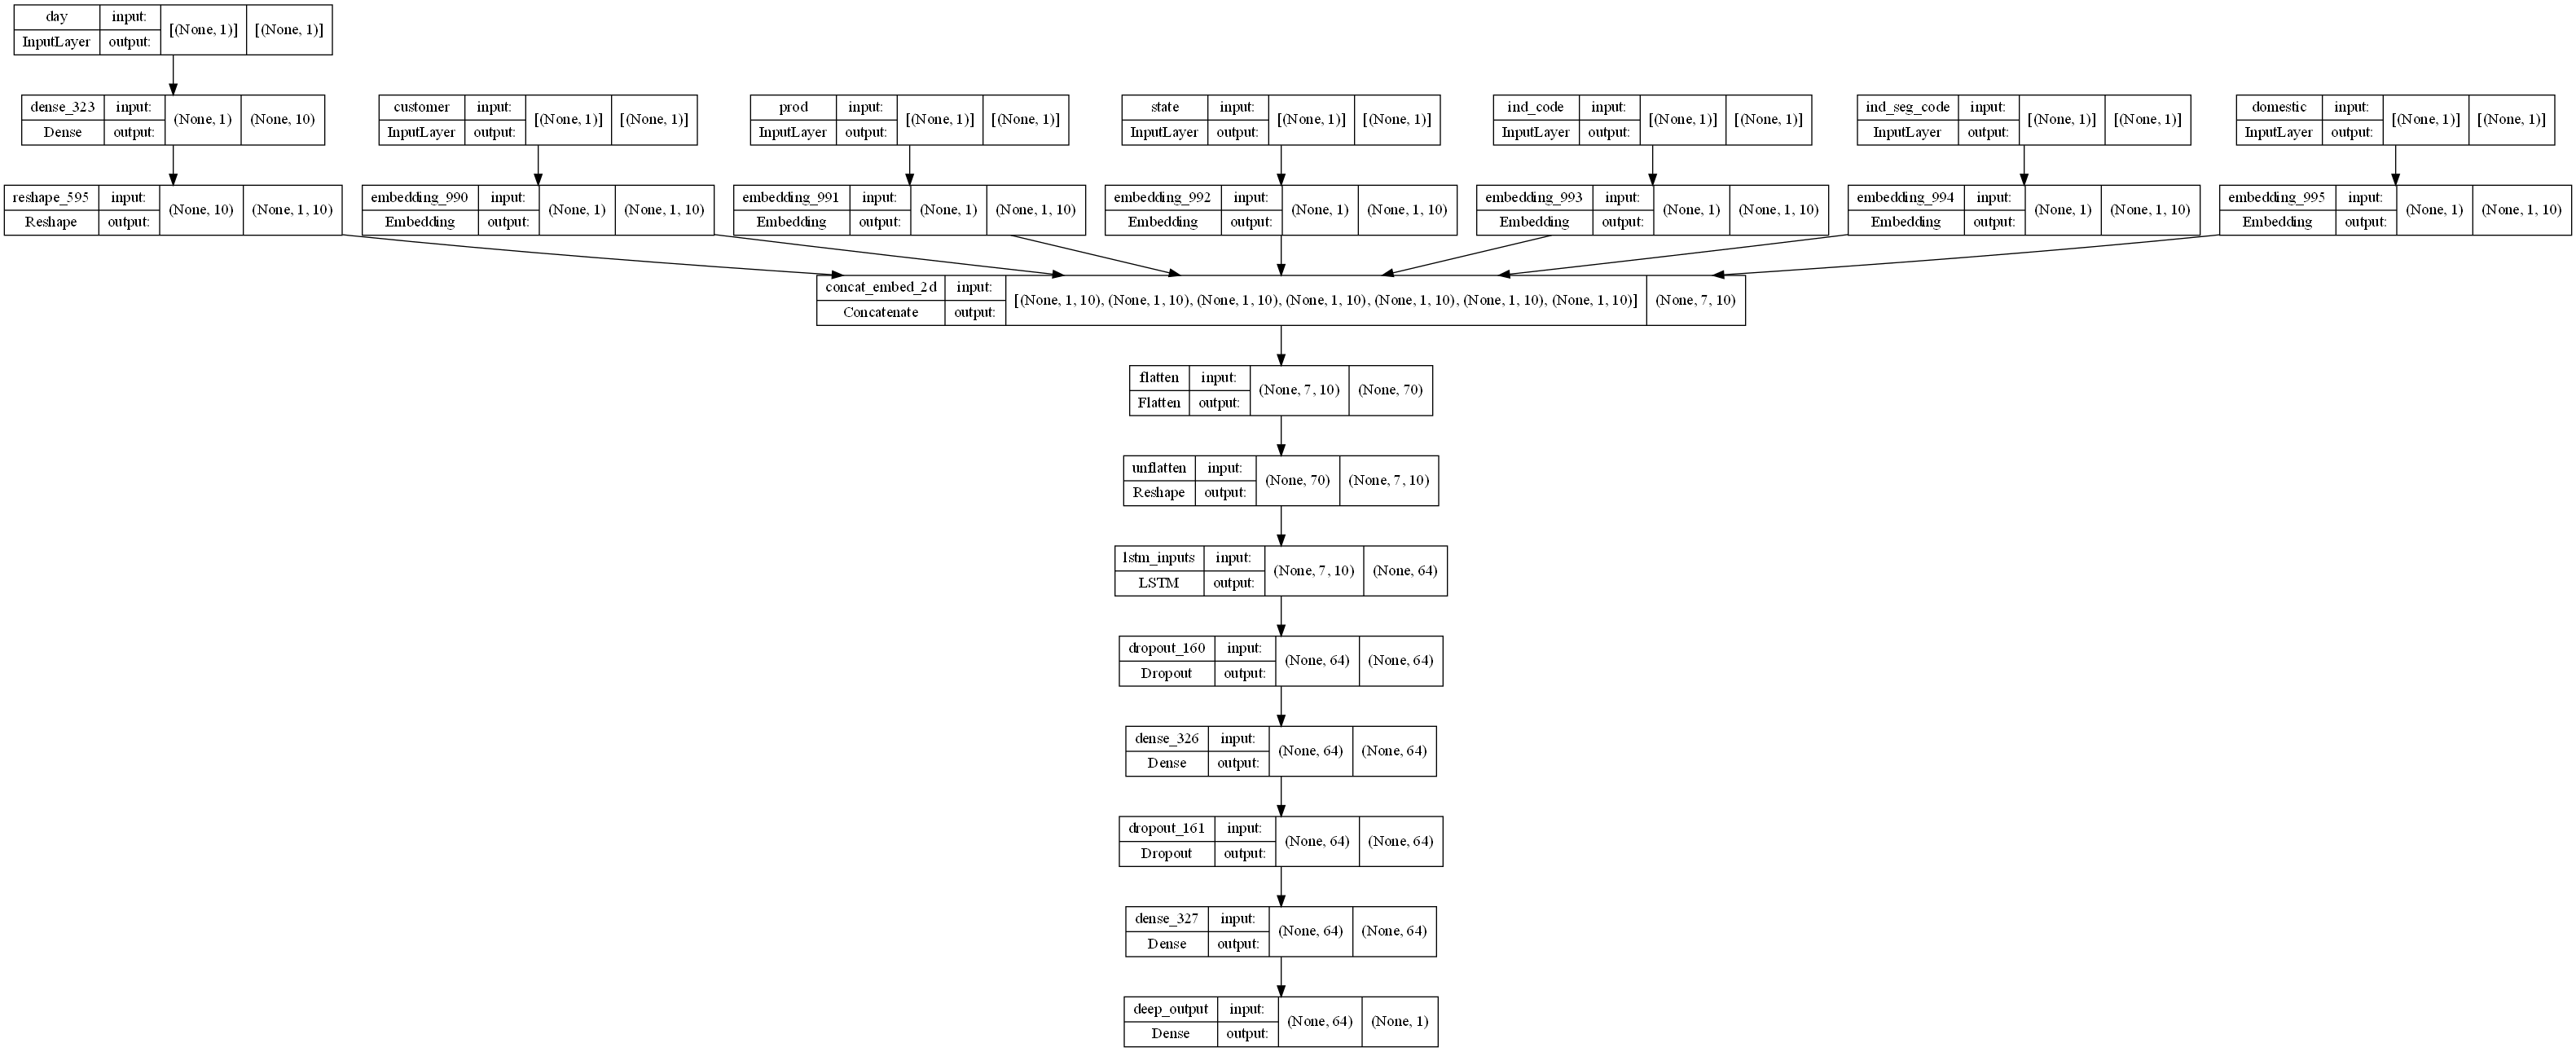

In [177]:
def lstm_part(embed_2d, lstm_dim, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    """
    LSTM = LSTM neural network
    
    args:
        embed_2d: keras.inputs -> embeding layer from 2nd order FM same dimensionality as FM part (should perhaps be different)
        lstm_dim: arr[int] -> lstm layer dimensions (currently only one supported due to dimensionality inconsistencies)
        dnn_dim: arr[int] -> dnn layer dimensions 
        dnn_dr: float -> dropout rate, same for all layers
        k_reg: tuple[float, float] -> kernel weights regularization (L1, L2)
        a_reg: tuple[float, float] -> activation unit regularization (L1, L2)
        act_fun: ="relu"
    returns:
        y_dnn: keras.model for LSTM
    """
    
    num_inputs, cat_inputs = inputs
    
    # flat embed layers from 3D to 2D tensors
    # flatten and unflatten (needed for concetanation)
    y_dnn = Flatten(name = 'flatten')(embed_2d)
    y_dnn = Reshape(embed_2d.shape[1:], name = "unflatten")(y_dnn)
    
    y_dnn = LSTM(lstm_dim[0], activation=lstm_fun, return_sequences=False, name="lstm_inputs",
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn) # Flatten(name = 'flat_embed_2d')(embed_2d)

    
    # traverse through layers
    for h in dnn_dim:
        y_dnn = Dropout(dnn_dr)(y_dnn) # add dropout layer
        y_dnn = Dense(h, activation=act_fun,
                      kernel_regularizer=regularizers.L1L2(l1=k_reg[0], l2=k_reg[1]),
                      activity_regularizer=regularizers.L1L2(l1=a_reg[1], l2=a_reg[1]))(y_dnn)
    y_dnn = Dense(1, activation=act_fun, name = 'deep_output')(y_dnn)
    
    return y_dnn

# display LSTM model
y_dnn = lstm_part(embed_2d, [64], [64, 64], 0.5)
fm_model_dnn = Model(inputs, y_dnn)
print(fm_model_dnn.outputs)
plot_model(fm_model_dnn, show_shapes=True, show_layer_names=True)

### 1.2 Models

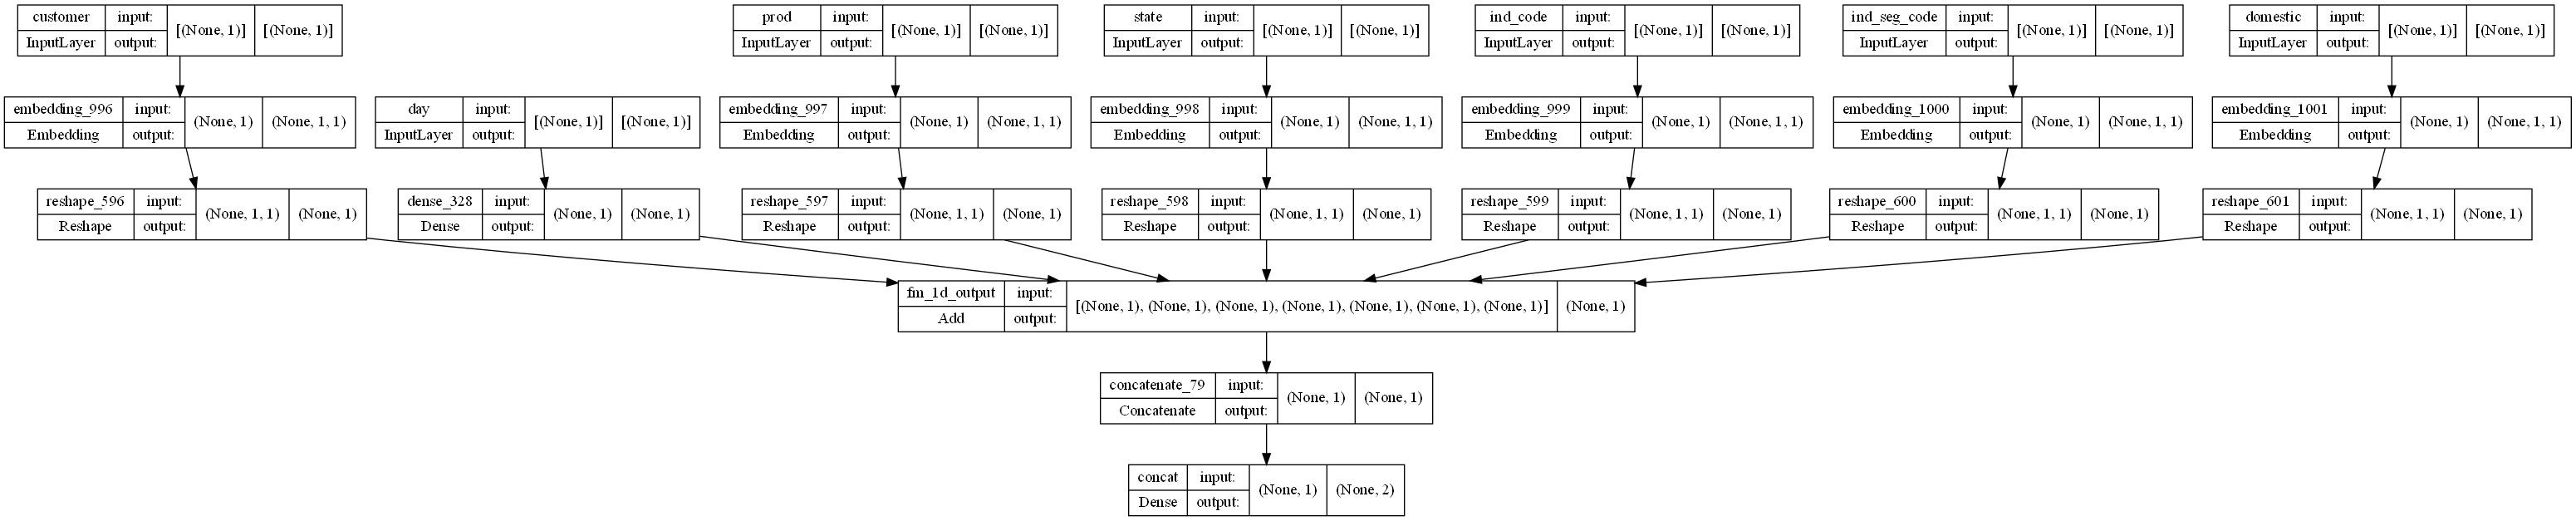

In [178]:
def mf_model():
    """
        Wrapper function for 1st order FM.
        
        args:
            (No parameters necesary.)
        returns:
            mf_model: keras.model for 1st order FM
    """
    inputs = define_input_layers(transformed) # specify inputs
    y_fm_1d = fm_1d(inputs)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d])
    y = Dense(2, name = "concat")(y)
    # Uncomment for binary classification (results worse than for regression)
    # y = Softmax(name = 'deepfm_output')(y)
    mf_model = Model(inputs, y)
    return mf_model

MF = mf_model()
plot_model(MF, show_shapes=True, show_layer_names=True)

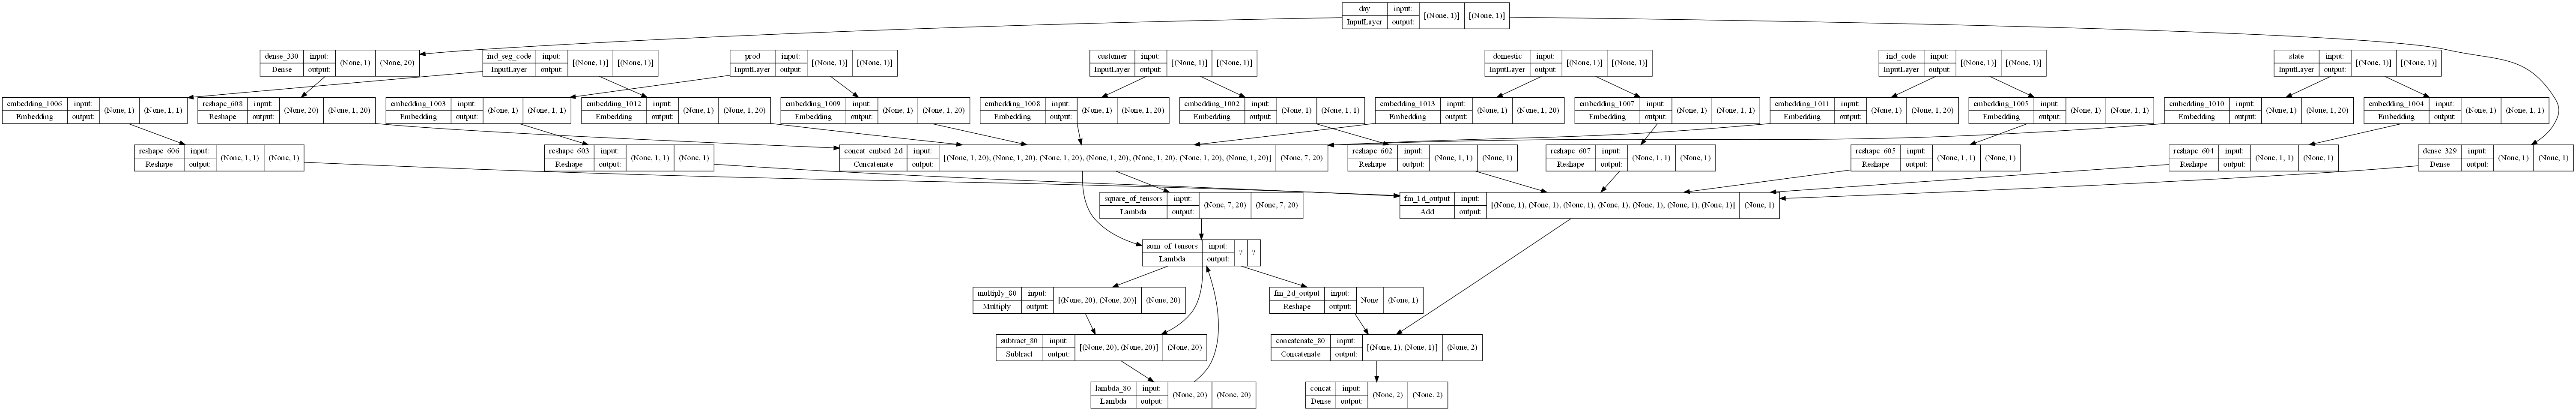

In [179]:
# Default parameters used without hyperparameter tunning
FM_params = {
    'k':20
}

def fm_model(k):
    """
        Wrapper function for 2nd order FM.
        
        args:
            k: int -> latent factors or embedding dimension
        returns:
            FM_model: keras.model for 2nd order FM (joins 1st and 2nd order FM parts)
            embed_2d: keras.inputs for embedding layers to use in DNN & LSTM models
    """
    inputs = define_input_layers(transformed) # specify inputs
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d])
    y = Dense(2, name = "concat")(y)
    # Uncomment for binary classification (results worse than for regression)
    # y = Softmax(name = 'fm_output')(y)
    FM_model = Model(inputs, y)
    
    return FM_model, embed_2d
FM, _ = fm_model(**FM_params)
plot_model(FM, show_shapes=True, show_layer_names=True)

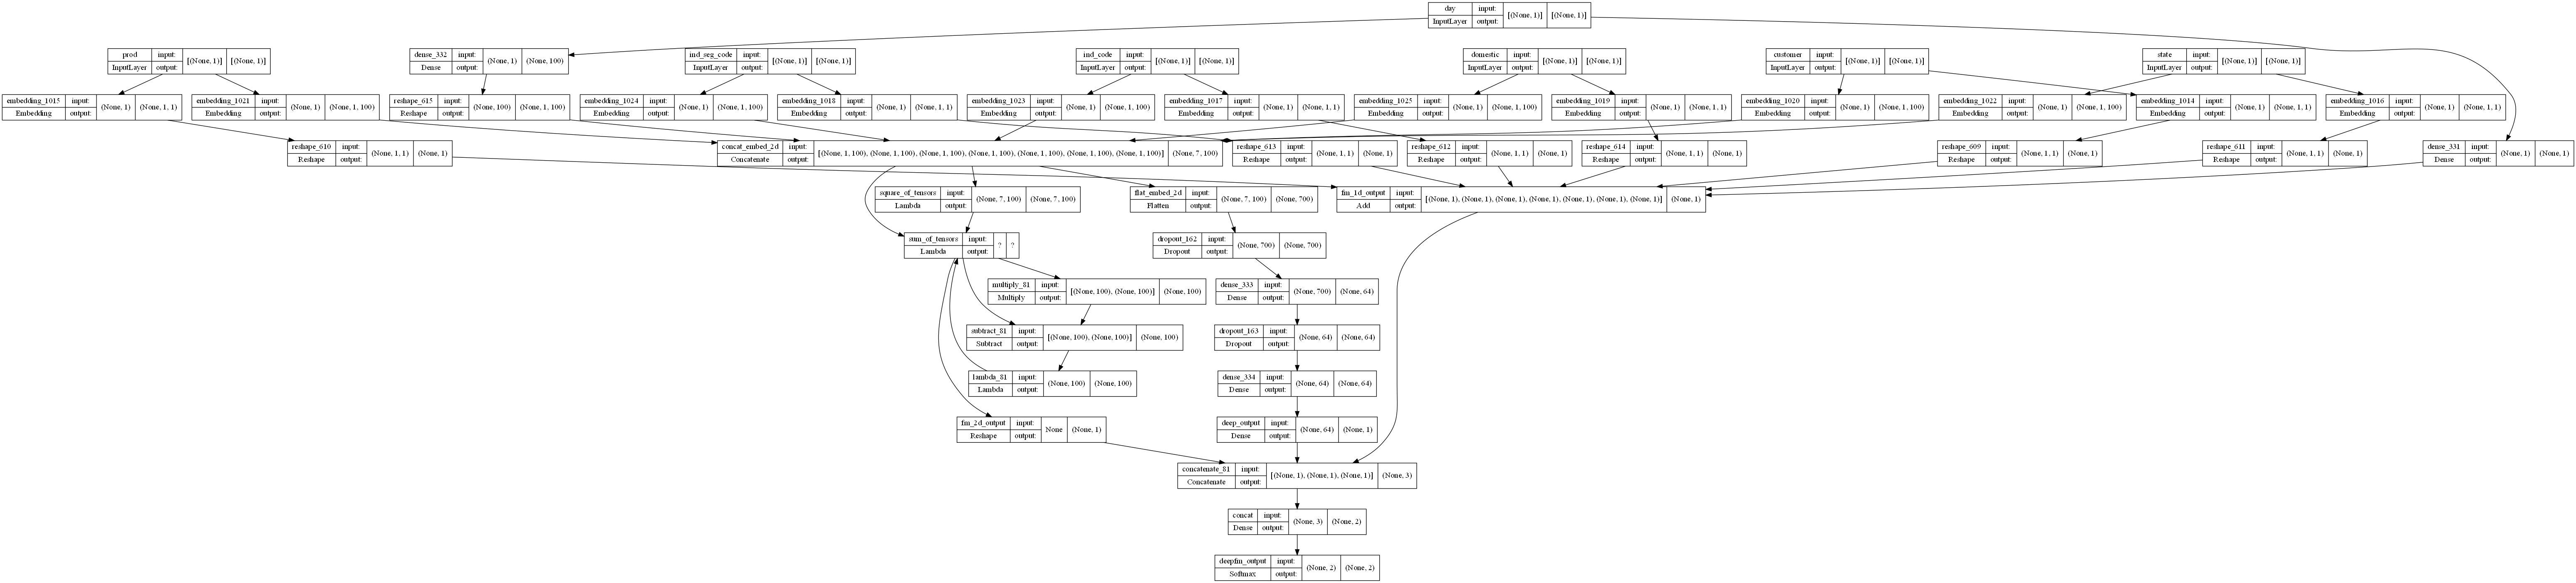

In [180]:
# Default parameters used without hyperparameter tunning
deepFM_params = {
    'k':100,
    'dnn_dim':[64, 64],
    'dnn_dr': 0.3
}

def deep_fm_model(k, dnn_dim, dnn_dr):
    """
        Wrapper function for deepFM.
        
        args:
            embed_2d: keras.inputs -> embeding layer from 2nd order FM same dimensionality as FM part (should perhaps be different)
            dnn_dim: arr[int] -> dnn layer dimensions 
            dnn_dr: float -> dropout rate, same for all layers
            k_reg: tuple[float, float] -> kernel weights regularization (L1, L2)
            a_reg: tuple[float, float] -> activation unit regularization (L1, L2)
            act_fun: ="relu"
        returns:
            deep_fm_model: keras.model for deepFM (joins FM and DNN parts)
    """
    inputs = define_input_layers(transformed) # specify inputs
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = dnn_part(embed_2d, dnn_dim, dnn_dr)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

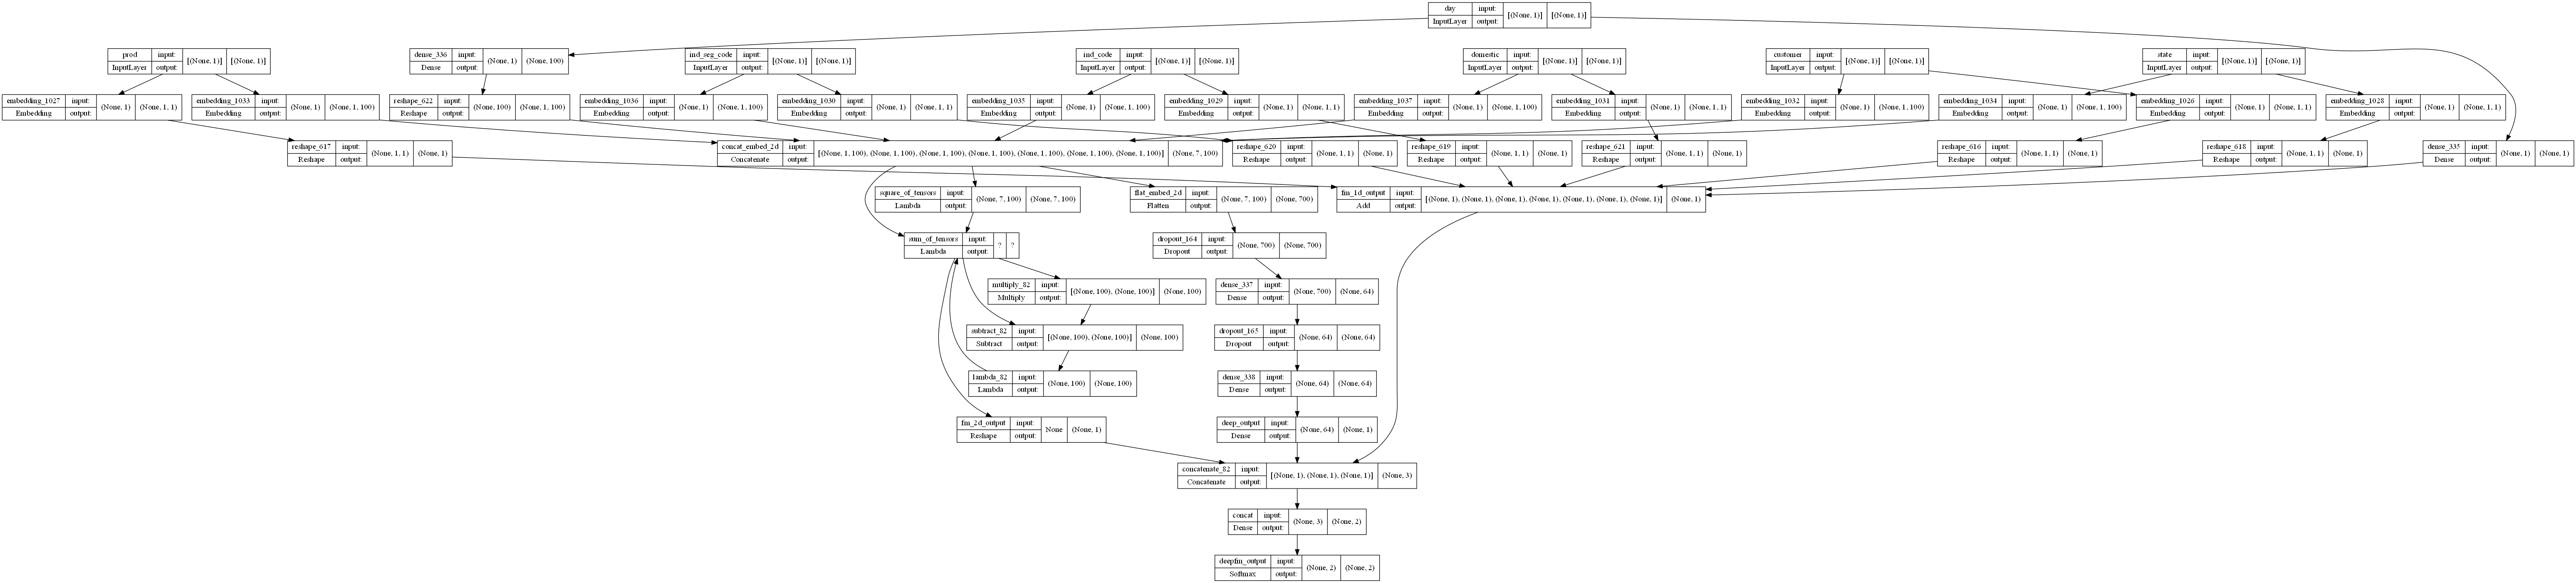

In [181]:
def lstm_fm_model(k, lstm_dim, dnn_dim, dnn_dr, k_reg=(1e-4, 1e-4), a_reg=(1e-4, 1e-4), act_fun="relu", lstm_fun="tanh"):
    """
        Wrapper function for LSTM deepFM.
        
        args:
            embed_2d: keras.inputs -> embeding layer from 2nd order FM same dimensionality as FM part (should perhaps be different)
            lstm_dim: arr[int] -> lstm layer dimensions (currently only one supported due to dimensionality inconsistencies)
            dnn_dim: arr[int] -> dnn layer dimensions 
            dnn_dr: float -> dropout rate, same for all layers
            k_reg: tuple[float, float] -> kernel weights regularization (L1, L2)
            a_reg: tuple[float, float] -> activation unit regularization (L1, L2)
            act_fun: ="relu"
        returns:
            deep_fm_model: keras.model -> LSTM deepFM model for prediction
    """
    inputs = define_input_layers(transformed)
    
    y_fm_1d = fm_1d(inputs)
    y_fm_2d, embed_2d = fm_2d(inputs, k)
    y_dnn = lstm_part(embed_2d, lstm_dim=lstm_dim, dnn_dim=dnn_dim, dnn_dr=dnn_dr, k_reg=k_reg, a_reg=a_reg, act_fun=act_fun, lstm_fun=lstm_fun)
    
    # combinded deep and fm parts
    y = Concatenate()([y_fm_1d, y_fm_2d, y_dnn])
    y = Dense(2, name = "concat")(y)
    # y = Softmax(name = 'deepfm_output')(y)
    deep_fm_model = Model(inputs, y)
    
    return deep_fm_model
deepFM = deep_fm_model(**deepFM_params)
plot_model(deepFM, show_shapes=True, show_layer_names=True)

## 2. Training

In [182]:
def df2xy(df, model):
    """
    Create feature matrix X and target y.
    
    args:
            df: pd.DataFrame -> transformed (transaction_history)
            model: keras.model -> built model to use this data
        returns:
            X: np.array[2d] -> features (include product, customer)
            y: np.array[1d] -> label (parchased - 1, not purchased - 0)
    """
    x = [df[inp.name].values for inp in model.inputs]
    y = df.label.values
    return x,np.asarray(y).astype('float32')

In [183]:
# Train 1st order FM - save model weights
mf_model_arr = []

# traverse through all folds
for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_1d = mf_model()
    train_x, train_y = df2xy(train, fm_model_1d) # specify model
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()  # get 2d array for True/False probabilities (works with regression as well)
    fm_model_1d.compile(loss = 'mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/1d_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    # if train model exist dont train
    if not exists(f'./models/1d_{i}.h5'):
        # Train on entire train set
        train_history = fm_model_1d.fit(train_x, train_y, 
                                              epochs=100, batch_size=2048, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=False)
        
    mf_model_arr.append(fm_model_1d)
# fm_model_1d.load_weights(f"./models/1d_0.h5")

'\nmf_model_arr = []\n\nfor i, transaction_tuple in zip(range(len(transformations)), transformations):\n    train, test = transaction_tuple\n    fm_model_1d = mf_model()\n    train_x, train_y = df2xy(train, fm_model_1d)\n    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()\n    fm_model_1d.compile(loss = \'mse\', optimizer=\'adam\')\n    early_stop = EarlyStopping(monitor=\'val_loss\', patience=10)\n    model_ckp = ModelCheckpoint(filepath=f\'./models/1d_{i}.h5\', \n                                    monitor=\'val_loss\',\n                                    save_weights_only=True, \n                                    save_best_only=True)\n    callbacks = [early_stop, model_ckp]\n    if not exists(f\'./models/1d_{i}.h5\'):\n        train_history = fm_model_1d.fit(train_x, train_y, \n                                              epochs=100, batch_size=2048, \n                                              validation_split=0.1, \n                                              call

In [184]:
# Train 2nd order FM - save model weights
fm_model_arr = []

# traverse through all folds
for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    fm_model_2d, _ = fm_model(**FM_params)
    train_x, train_y = df2xy(train, fm_model_2d)
    # train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    fm_model_2d.compile(loss = 'mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/2d_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    
    # if train model exist dont train
    if not exists(f'./models/2d_{i}.h5'):
        train_history = fm_model_2d.fit(train_x, train_y,
                                              epochs=100, batch_size=2048, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=False)
    fm_model_arr.append(fm_model_1d)
fm_model_2d.load_weights('./models/2d_0.h5')

"\nfm_model_arr = []\n\nfor i, transaction_tuple in zip(range(len(transformations)), transformations):\n    train, test = transaction_tuple\n    fm_model_2d, _ = fm_model(**FM_params)\n    train_x, train_y = df2xy(train, fm_model_2d)\n    # train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()\n    fm_model_2d.compile(loss = 'mse', optimizer='adam')\n    early_stop = EarlyStopping(monitor='val_loss', patience=10)\n    model_ckp = ModelCheckpoint(filepath=f'./models/2d_{i}.h5', \n                                    monitor='val_loss',\n                                    save_weights_only=True, \n                                    save_best_only=True)\n    callbacks = [early_stop, model_ckp]\n    if not exists(f'./models/2d_{i}.h5'):\n        train_history = fm_model_2d.fit(train_x, train_y,\n                                              epochs=100, batch_size=2048, \n                                              validation_split=0.1, \n                                              c

In [188]:
# Train deepFM - save model weights
deepfm_model_arr = []

# traverse through all folds
for i, transaction_tuple in zip(range(len(transformations)), transformations):
    train, test = transaction_tuple
    deepfm_model = deep_fm_model(**deepFM_params)
    train_x, train_y = df2xy(train, deepfm_model)
    train_y = pd.get_dummies(pd.Series(train_y)).to_numpy()
    deepfm_model.compile(loss = 'binary_crossentropy', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    model_ckp = ModelCheckpoint(filepath=f'./models/deepfm_{i}.h5', 
                                    monitor='val_loss',
                                    save_weights_only=True, 
                                    save_best_only=True)
    callbacks = [early_stop, model_ckp]
    if not exists(f'./models/deepfm_{i}.h5'):
        train_history = deepfm_model.fit(train_x, train_y, 
                                              epochs=100, batch_size=2048, 
                                              validation_split=0.1, 
                                              callbacks = callbacks,
                                              verbose=False)
    deepfm_model_arr.append(deepfm_model)
deepfm_model.load_weights(f'./models/deepfm_0.h5')

## 3. Evaluation

### 3.1 Score (for top k products)

In [189]:
eval_models = [("1d", mf_model_arr), ("2d", fm_model_arr), ("deepfm", deepfm_model_arr)]
eval_k = [1, 2, 3, 5, 10, 15, 20, 30]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}

# traverse through all combination of interested parameters
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            test = test.drop_duplicates()
            # test = test[test["prod"].apply(lambda x: x in train_prod)] # keep only products present in train (compatibility reasons)
            if predict_only_new_products:  # keep only new products for testing
                bought_prod = {customer: set(train[train.customer == customer]["prod"].unique()) for customer in train.customer.unique()}
                test = test[~test.apply(lambda row: row["prod"] in bought_prod[row["customer"]], axis=1)]
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}.h5')
            
            # create X,y set for model
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            
            # predict values
            pred_deepfm = test.copy()
            pred_deepfm["score"] = model.predict(test_x,
                                        batch_size=2048)[:, 1]
            
            # pick only top k products 
            eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
            print(f"Hit@{k} score {model_name} (CV-{i}): {ana.label.mean()}", end="\r")
            hit_eval[model_name][k]["hit_rate"].append(ana.label.mean()) 
        print("------------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


In [190]:
# print and save hit rates
res = pd.DataFrame(columns=["k", "hit", "std"])
for k in eval_k:
    for model_tuple in eval_models:
        model_name, model = model_tuple
        hit_arr = hit_eval[model_name][k]['hit_rate']
        print(f"Hit@{k} score {model_name} : {np.mean(hit_arr)} \pm {np.std(hit_arr)}")
        res = res.append({"k": k,
                          "model": model_name,
                          "hit": np.mean(hit_arr),
                          "std": np.std(hit_arr)}, ignore_index=True)
    print("-----------------------------------------------------------------------")
res.to_csv("./results/dummy_hit.csv", index=False)

Hit@1 score deepfm : 0.3111814775904163 \pm 0.04055124859905916
-----------------------------------------------------------------------
Hit@2 score deepfm : 0.42956945848392464 \pm 0.038539698815836305
-----------------------------------------------------------------------
Hit@3 score deepfm : 0.48611191036577406 \pm 0.026431793168261303
-----------------------------------------------------------------------
Hit@5 score deepfm : 0.5653201540745009 \pm 0.02545641345851482
-----------------------------------------------------------------------
Hit@10 score deepfm : 0.6789576937184738 \pm 0.030019415908959474
-----------------------------------------------------------------------
Hit@15 score deepfm : 0.7415578772998846 \pm 0.021121541333438288
-----------------------------------------------------------------------
Hit@20 score deepfm : 0.791505705641048 \pm 0.016893361305632282
-----------------------------------------------------------------------
Hit@30 score deepfm : 0.838631685624068

### 3.2 F1-Score

In [219]:
eval_models = [("1d", mf_model_arr), ("2d", fm_model_arr), ("deepfm", deepfm_model_arr)]
eval_k = [1, 2, 3, 5, 10, 15, 20, 30, 50]
hit_eval = {eval_name: {k: {"hit_rate": []} for k in eval_k} for eval_name, eval_model in eval_models}
thresholds = [0.01 * i for i in range(0, 100)]
f1_res = pd.DataFrame(columns=["k", "threshold", "f1"])

# traverse through all combination of interested parameters
for k in eval_k:
    for model_tuple in eval_models:
        for i, transaction_tuple in zip(range(len(transformations)), transformations):
            train, test = transaction_tuple
            model_name, model = model_tuple
            model.load_weights(f'./models/{model_name}_{i}.h5') # load trained weights
            
            # create X,y set for model
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            
            # make predictions
            pred_model = test.copy()
            pred_model["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            
            # pick top k products
            eval_model = pred_model.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            
            # calculate F1-scores for all models
            for t in thresholds:
                eval_model["above_thresh"] = eval_model.score > t # mark those above and bellow threshold (POSITIVE)
                eval_model["TP"] = eval_model["above_thresh"] & (eval_model.label == 1)
                eval_model["FN"] = ~eval_model["above_thresh"] & (eval_model.label == 1)
                TP = np.array(eval_model[["day", "customer", "TP"]].groupby(["day", "customer"]).sum().reset_index()["TP"]).sum()
                FN = np.array(eval_model[["day", "customer", "FN"]].groupby(["day", "customer"]).sum().reset_index()["FN"]).sum()
                P = np.array(eval_model[["day", "customer", "above_thresh"]].groupby(["day", "customer"]).sum().reset_index()["above_thresh"]).sum()
                not_sure_what = len(eval_model[(eval_model.label == 1)]["prod"].unique()) # len(test[(test.label == 1)]["prod"].unique())

                precision = TP / P
                recall = TP / test[test.label == 1][["customer", "prod"]].groupby("customer").nunique()["prod"].sum()

                f1_res = f1_res.append({
                    "k": k,
                    "algorithm": model_name,
                    "threshold": t,
                    "f1": 2 * (precision * recall) / (precision + recall)
                }, ignore_index=True)
        print("------------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------------


In [220]:
# calculate mean for all folds
f1_plt = f1_res.groupby(["algorithm", "threshold"]).mean().reset_index()
f1_plt["std"] = f1_res.groupby(["algorithm", "threshold"]).std().reset_index().f1
f1_plt.to_csv(f"./results/f1_{prod_class}.csv", index=False)

In [221]:
f1_plt

algorithm  threshold     k        f1       std
0     deepfm       0.00  50.0  0.216734  0.012848
1     deepfm       0.01  50.0  0.225927  0.012690
2     deepfm       0.02  50.0  0.227377  0.012398
3     deepfm       0.03  50.0  0.228432  0.012257
4     deepfm       0.04  50.0  0.229437  0.012210
..       ...        ...   ...       ...       ...
95    deepfm       0.95  50.0  0.305724  0.014693
96    deepfm       0.96  50.0  0.309605  0.015509
97    deepfm       0.97  50.0  0.312798  0.015464
98    deepfm       0.98  50.0  0.314780  0.019126
99    deepfm       0.99  50.0  0.307674  0.025780

[100 rows x 5 columns]

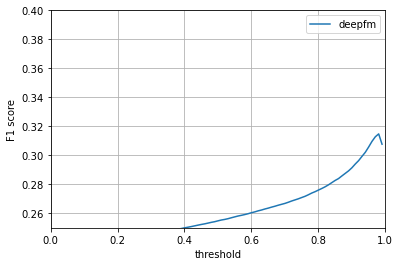

In [223]:
# plot F1-score for all thresholds and k's
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
my_k = [50]
f1_plt = f1_res.groupby(["algorithm", "threshold"]).mean().reset_index()
for k in my_k:
    for i, model_tuple in zip(range(len(eval_models)), eval_models):
        model_name, model = model_tuple
        bol = (f1_plt.algorithm == model_name)
        ax.plot(f1_plt[bol]["threshold"], f1_plt[bol]["f1"], label=f"{model_name}")
        ax.legend()
        # ax[0].axis('square')
        ax.set_ylim(0.25, 0.4)
        ax.set_xlim(0, 1.0)
        ax.set_xlabel("threshold")
        ax.set_ylabel("F1 score")
        ax.grid()
plt.show()

In [ ]:
transformed

In [ ]:
f1_plt

In [ ]:
for k in [10, 20, 30]:
    for thresh in [0.7, 0.8, 0.9]:
        for model_tuple in [("MF", fm_model_1d), ("FM", fm_model_2d), ("deepFM", deepfm_model)]:
            model_name, model = model_tuple
            test_x, test_y = df2xy(test, model)
            test_y = pd.get_dummies(pd.Series(test_y)).to_numpy()
            pred_deepfm = test.copy()
            pred_deepfm["score"] = model.predict(test_x,
                                        batch_size=256)[:, 1]
            eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
            ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
            print(f"Hit@{k} score {model_name}: {ana.label.mean()}")
        print("------------------------------------------------------------------------------------------------")

In [ ]:
res = pd.DataFrame(columns=[""])
for k in [2, 3, 5, 10, 15, 20]:
    eval_1d = pred_1d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_1d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score MF: {ana.label.mean()}")
    eval_2d = pred_2d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_2d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score FM: {ana.label.mean()}")
    eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score deepFM: {ana.label.mean()}")
    print("------------------------------------------------------------------------------------------------")

### 3.2 F1-Score (for values above threshold) 

In [ ]:
for k in [10, 20, 30]:
    eval_1d = pred_1d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_1d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score MF: {ana.label.mean()}")
    eval_2d = pred_2d.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_2d[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score FM: {ana.label.mean()}")
    eval_deepfm = pred_deepfm.sort_values(['score'], ascending=[False]).groupby(["day", "customer"]).head(k)
    ana = eval_deepfm[["day", "customer", "label"]].groupby(["day", "customer"]).max().reset_index()
    print(f"Hit@{k} score deepFM: {ana.label.mean()}")
    print("------------------------------------------------------------------------------------------------")